In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from robocop import fetch_events,evaluate_and_report,build_pid_stream
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
NUM_SYSCALLS = 473
NGRAM = 4
NU = 0.01
GAMMA = 0.01


In [3]:
encoder = OneHotEncoder(
    categories=[np.arange(NUM_SYSCALLS)] * NGRAM,
)

encoder.fit(np.zeros((1, NGRAM), dtype=np.int32))


OneHotEncoder(categories=[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106...
       377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472])])

In [4]:


def extract_features(window, syscall_to_id=None):
    syscalls = [e["syscall_num"] for e in window]
    if len(syscalls) < NGRAM:
        return np.zeros(NUM_SYSCALLS * NGRAM, dtype=np.float32)
    trigrams = np.array(
        [syscalls[i:i+NGRAM] for i in range(len(syscalls) - NGRAM + 1)],
        dtype=np.int32
    )
    onehot = encoder.transform(trigrams)
    return np.asarray(onehot.sum(axis=0)).ravel().astype(np.float32)

def build_X(windows, syscall_to_id=None):
    return np.array([extract_features(w) for w in windows], dtype=np.float32)
    

In [5]:
# OneHotEncoding Of Ngrams
print(build_X([[{"syscall_num":1},{"syscall_num":4},{"syscall_num":472},{"syscall_num":472}],
               [{"syscall_num":4},{"syscall_num":2},{"syscall_num":472}]]))

[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
train_events = fetch_events("test = '5'",100000)

In [7]:
extract_features(train_events[0:4])

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [8]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14'",100_000)

In [9]:
len(train_events)

100000

In [10]:
train_windows = build_pid_stream(train_events)
X_train = build_X(train_windows)

In [11]:
X_train.shape

(82, 1892)

In [44]:
def show_pca_as_graph(X):
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("X_train projected to 2D using PCA")
    plt.show()

NameError: name 'X' is not defined

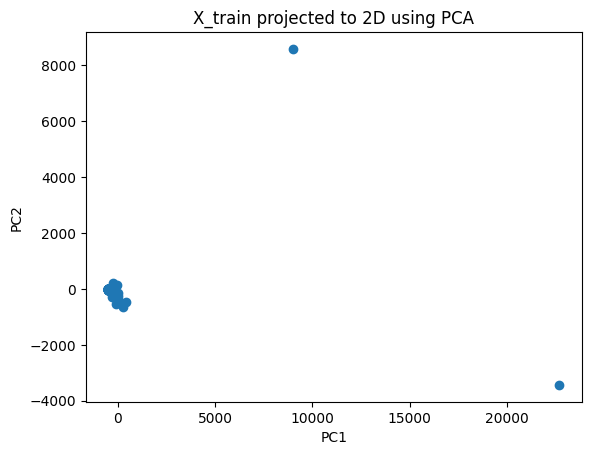

In [45]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("X_train projected to 2D using PCA")
plt.show()

In [14]:
virus_events = fetch_events("test = '10'",100_000)
virus_windows = build_pid_stream(virus_events)
X_virus = build_X(virus_windows)

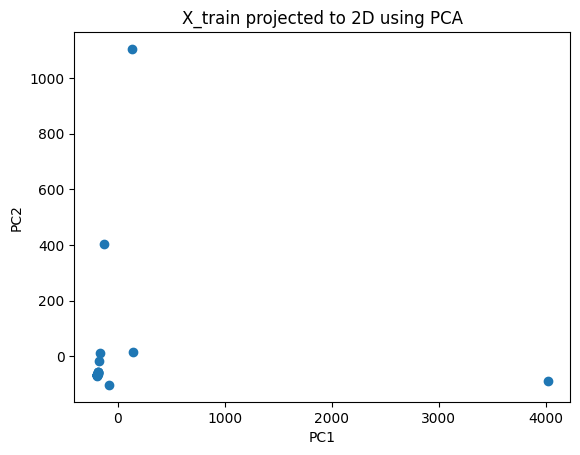

In [46]:

X_2d = pca.fit_transform(X_virus)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("X_train projected to 2D using PCA")
plt.show()

In [16]:
normal_events = fetch_events("test = '16'",10_000)
normal_windows = build_pid_stream(normal_events)
X_normal = build_X(normal_windows)

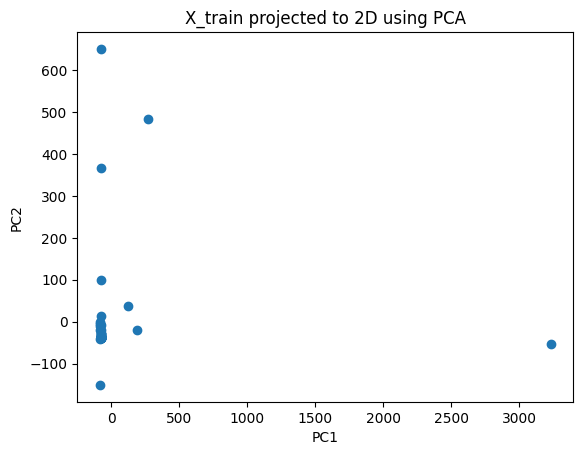

In [17]:
show_pca_as_graph(X_normal)

In [18]:

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

model = OneClassSVM(kernel="rbf", nu=NU, gamma=0.01)
model.fit(X_train_scaled)

print("[✓] Model trained")



[✓] Model trained


In [19]:
from collections import defaultdict
import robocop
def evaluate_and_report(label: str, windows, X, model, scaler):
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled)                 # +1 normal, -1 anomaly
    scores = model.decision_function(X_scaled)      # more negative => more anomalous
    totatl = [] 

    for i, (p, s) in enumerate(zip(preds, scores)):
        if p != -1:
            continue
        
        w = windows[i]
        proc_name = w[0]["process_name"]
        pid = w[0]["pid"]
        syscalls = [robocop.convert_syscall_num_to_string(e["syscall_num"]) for e in w]

        totatl.append({
                "pid": pid,
                "name" : proc_name,
                "score": float(s),
                "syscalls": syscalls,
            })

    return totatl

In [20]:

normal_report = evaluate_and_report(
    label="NORMAL",
    windows=list(normal_windows),
    X=X_normal,
    model=model,
    scaler=scaler
)

virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)



In [21]:
normal_report

[{'pid': 7300,
  'name': 'g\\Everything.exe',
  'score': -0.005522875041385315,
  'syscalls': ['NtReleaseWorkerFactoryWorker',
   'NtAssociateWaitCompletionPacket',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtReleaseWorkerFactoryWorker',
   'NtAssociateWaitCompletionPacket',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtClearEvent',
   'NtWaitForSingleObject',
   'NtReadFile',
   'NtReadFile',
   'NtReadFile',
   'NtReleaseWorkerFactoryWorker',
   'NtReleaseWorkerFactoryWorker',
   'NtAssociateWaitCompletionPacket',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetInformationThread',
   'NtClearEvent',
   'NtClearEvent',
   'NtWaitForSingleObject',
   'NtSetEvent',
   'NtW

In [22]:
virus_report

[{'pid': 6588,
  'name': 'em32\\svchost.exe',
  'score': -0.02420415255012044,
  'syscalls': ['NtQueryLicenseValue',
   'NtOpenKeyEx',
   'NtQueryKey',
   'NtOpenKeyEx',
   'NtClose',
   'NtQueryValueKey',
   'NtClose',
   'NtAssociateWaitCompletionPacket',
   'NtOpenKeyEx',
   'NtFreeVirtualMemory',
   'NtQueryKey',
   'NtFreeVirtualMemory',
   'NtOpenKeyEx',
   'NtFreeVirtualMemory',
   'NtFreeVirtualMemory',
   'NtClose',
   'NtQueryValueKey',
   'NtFreeVirtualMemory',
   'NtClose',
   'NtFreeVirtualMemory',
   'NtOpenKeyEx',
   'NtQueryKey',
   'NtFreeVirtualMemory',
   'NtOpenKeyEx',
   'NtFreeVirtualMemory',
   'NtClose',
   'NtFreeVirtualMemory',
   'NtQueryValueKey',
   'NtClose',
   'NtQueryLicenseValue',
   'NtOpenKeyEx',
   'NtFreeVirtualMemory',
   'NtQueryKey',
   'NtFreeVirtualMemory',
   'NtOpenKeyEx',
   'NtClose',
   'NtFreeVirtualMemory',
   'NtQueryValueKey',
   'NtFreeVirtualMemory',
   'NtClose',
   'NtFreeVirtualMemory',
   'NtFreeVirtualMemory',
   'NtOpenKeyEx',

In [23]:
len(train_events)

100000

In [24]:
virus_events = fetch_events("test = '5'",100_000)
virus_windows = build_pid_stream(virus_events)
X_virus = build_X(virus_windows)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)

virus_report


[{'pid': 688,
  'name': 'm32\\WUDFHost.exe',
  'score': -0.024039170764761055,
  'syscalls': ['NtSetEvent',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',


In [25]:
virus_report

[{'pid': 688,
  'name': 'm32\\WUDFHost.exe',
  'score': -0.024039170764761055,
  'syscalls': ['NtSetEvent',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',


In [41]:
print(normal_windows)

dict_values([[{'id': 7516625, 'ts': 1768483922640896.0, 'pid': 7300, 'tid': 7304, 'syscall_num': 369, 'process_name': 'g\\Everything.exe', 'handle_operation': None, 'handle_1_val': 18446744071562078104, 'handle_2_val': None, 'ret_handle': None, 'closed_handle': None, 'handle_1_access': 2, 'handle_2_access': None, 'handle_1_access_mode': 160, 'handle_2_access_mode': None}, {'id': 7516656, 'ts': 1768483922640896.0, 'pid': 7300, 'tid': 7304, 'syscall_num': 144, 'process_name': 'g\\Everything.exe', 'handle_operation': None, 'handle_1_val': 18446744071562078076, 'handle_2_val': 18446744071562078104, 'ret_handle': None, 'closed_handle': None, 'handle_1_access': 1, 'handle_2_access': 2, 'handle_1_access_mode': 32, 'handle_2_access_mode': 160}, {'id': 7516661, 'ts': 1768483922640896.0, 'pid': 7300, 'tid': 7304, 'syscall_num': 419, 'process_name': 'g\\Everything.exe', 'handle_operation': None, 'handle_1_val': 18446744071562078104, 'handle_2_val': 18446744071562078300, 'ret_handle': None, 'close

In [27]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_all_process_scores(results, max_processes=None):
    # Group scores by process name
    proc_scores = defaultdict(list)
    for r in results:
        proc_scores[r["name"]].append(r["score"])

    # Optionally limit number of processes (for readability)
    items = list(proc_scores.items())
    if max_processes:
        items = items[:max_processes]

    plt.figure(figsize=(12, 5))

    for proc_name, scores in items:
        plt.plot(scores, alpha=0.7)

    plt.axhline(0, linestyle="--")
    plt.xlabel("Window index (per process)")
    plt.ylabel("OCSVM score (lower = more anomalous)")
    plt.title("One-Class SVM anomaly scores – all processes")

    plt.grid(True)
    plt.tight_layout()
    plt.show()


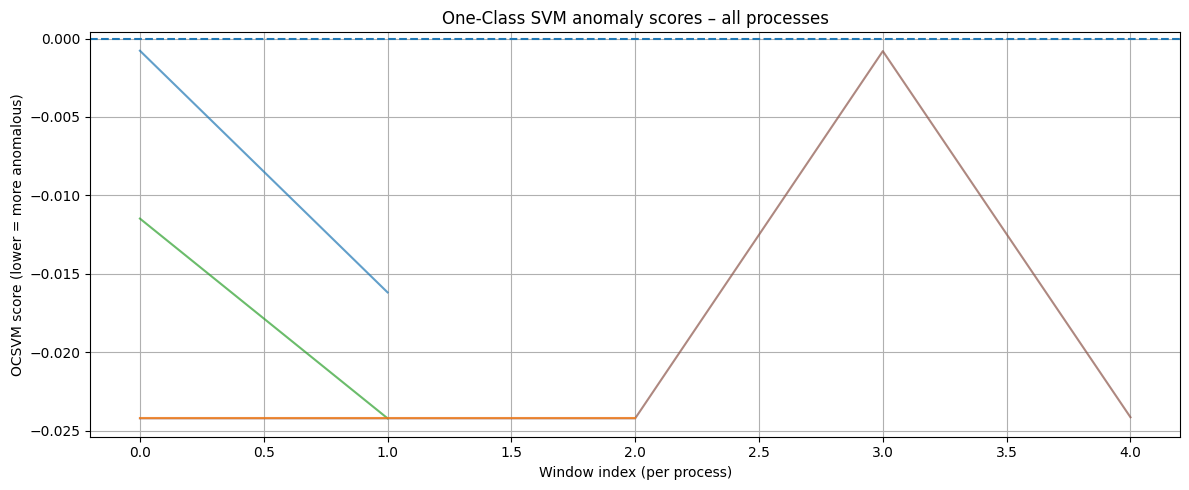

In [28]:
plot_all_process_scores(virus_report)

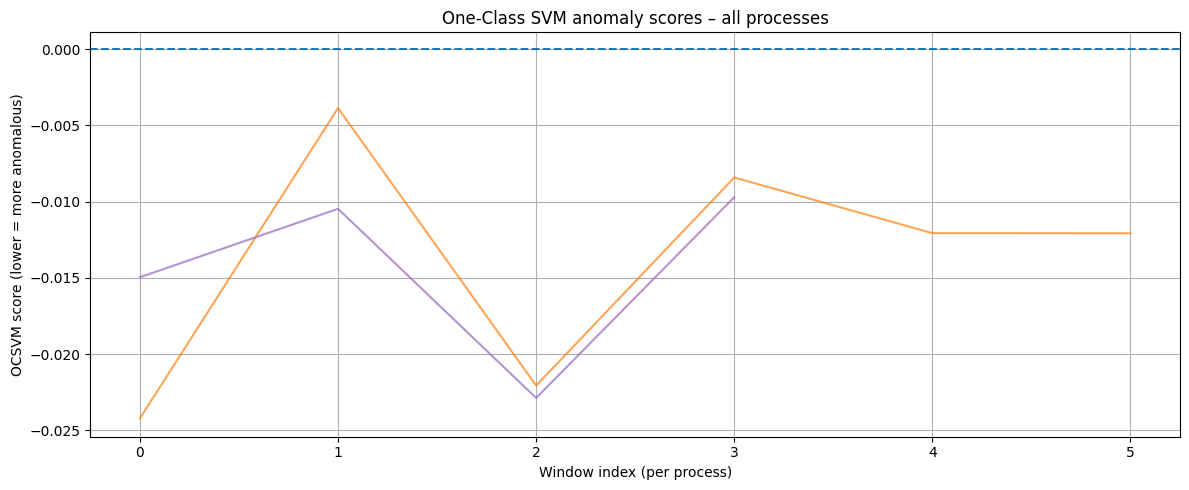

In [29]:
plot_all_process_scores(normal_report)

In [30]:
virus_events = fetch_events("test = '12'",100_000)
virus_windows = build_pid_stream(virus_events)
X_virus = build_X(virus_windows)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)


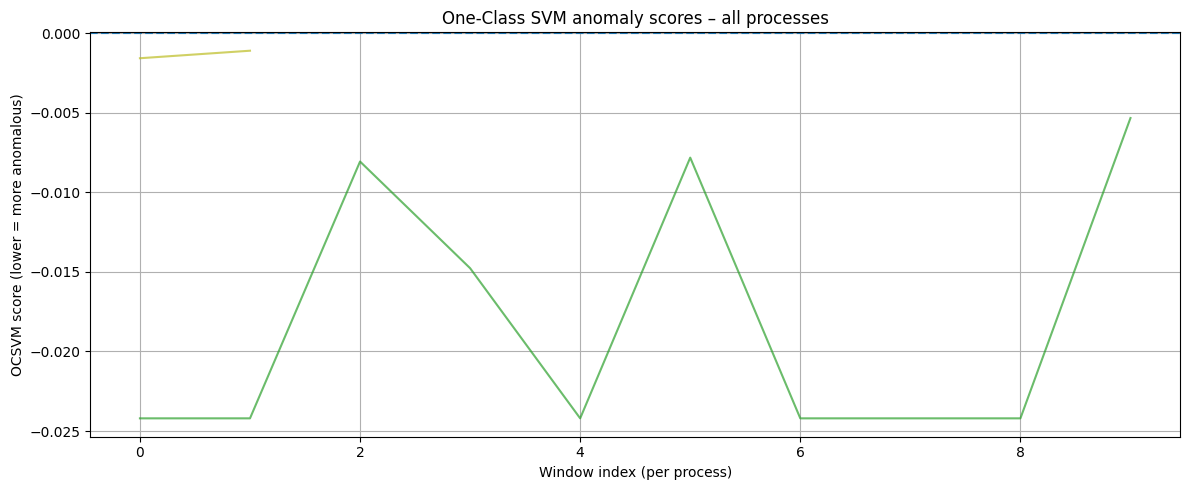

In [31]:
plot_all_process_scores(virus_report)

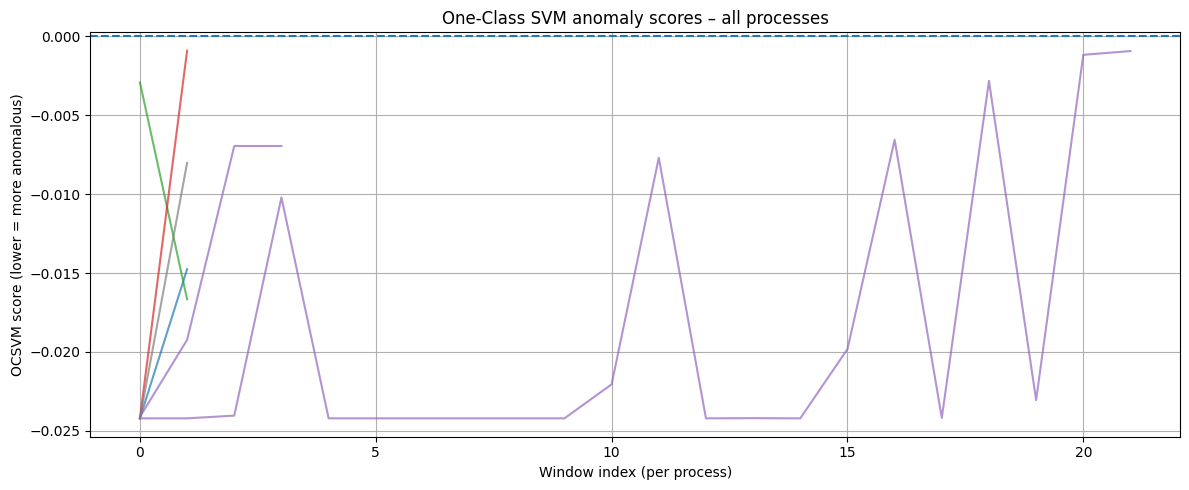

In [32]:
virus_events = fetch_events("test = '15'",100_000)
virus_windows = build_pid_stream(virus_events)
X_virus = build_X(virus_windows)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)
plot_all_process_scores(virus_report)

In [33]:
virus_report

[{'pid': 6388,
  'name': 'perienceHost.exe',
  'score': -0.02420415255012044,
  'syscalls': ['NtWaitForMultipleObjects',
   'NtSetIoCompletion',
   'NtWaitForMultipleObjects',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtReleaseWorkerFactoryWorker',
   'NtSetInformationThread',
   'NtSetInformationThread',
   'NtAlpcSendWaitReceivePort',
   'NtWaitForMultipleObjects',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtClearEvent',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtSetTimer2',
   'NtClearEvent',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtWaitForMultipleObjects',
   'NtSetTimer2',
   'NtSetIoCompletion',
   'NtReleaseWorkerFactoryWorker',
   'NtQueryInformationThread',
   'NtWaitForSingleObject

# Lets try to change the Kernel!

In [34]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

model = OneClassSVM(
    kernel="poly",
    degree=4,      
    gamma=0.01,      
    coef0=1.0,      
    nu=NU
)

model.fit(X_train_scaled)

print("[✓] Model trained (poly kernel)")

[✓] Model trained (poly kernel)


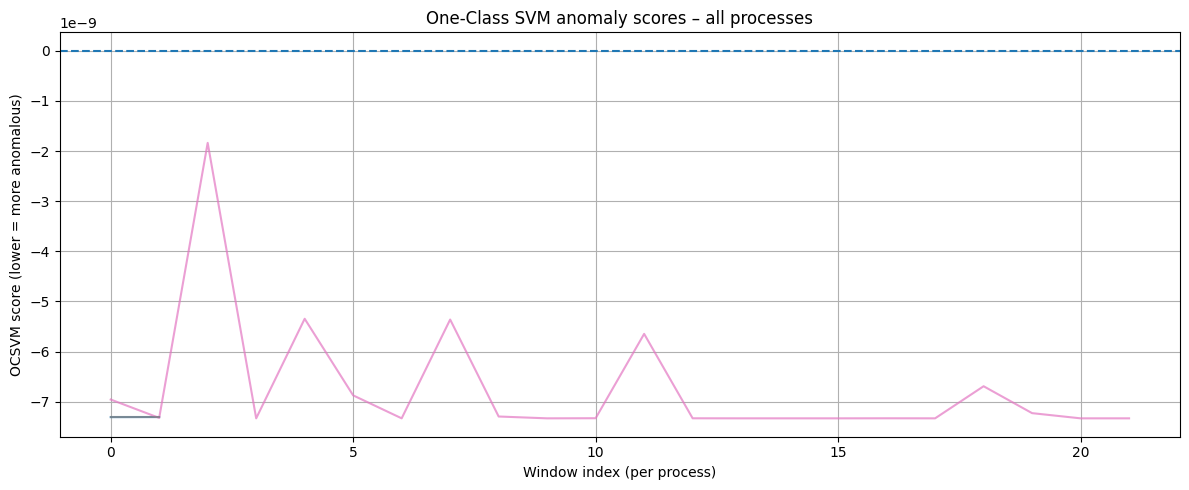

In [35]:
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)
plot_all_process_scores(virus_report)

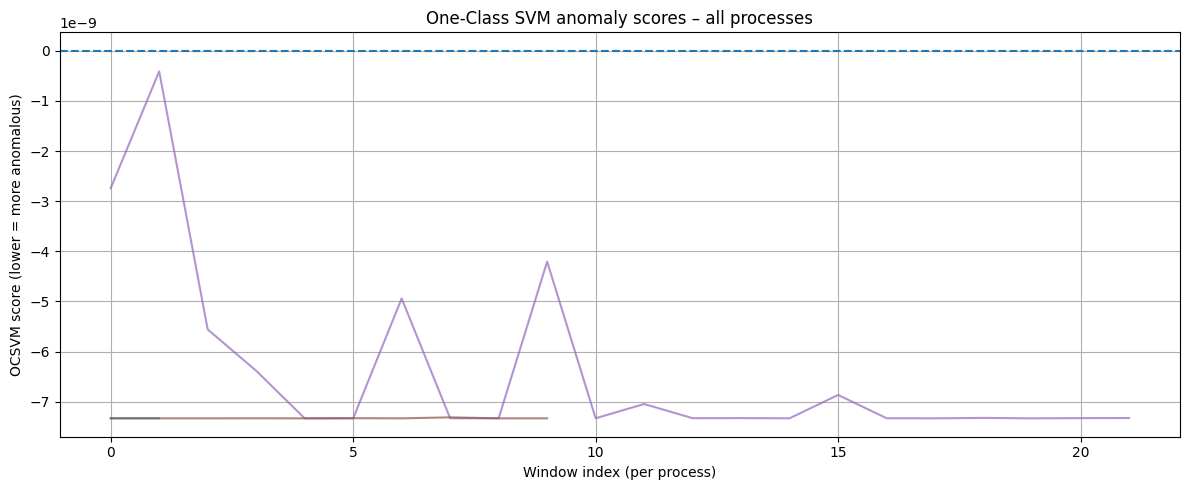

In [36]:
normal_report = evaluate_and_report(
    label="NORMAL",
    windows=list(normal_windows),
    X=X_normal,
    model=model,
    scaler=scaler
)
plot_all_process_scores(normal_report)


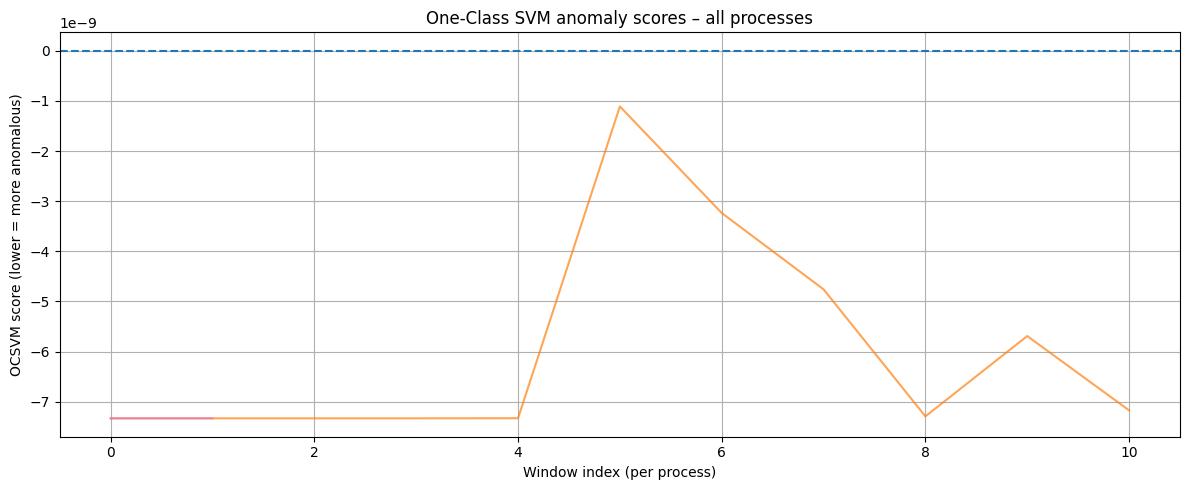

In [37]:
virus_events = fetch_events("test = '9'",100_000)
virus_windows = build_pid_stream(virus_events)
X_virus = build_X(virus_windows)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=list(virus_windows),
    X=X_virus,
    model=model,
    scaler=scaler
)
plot_all_process_scores(virus_report)

In [38]:
len(virus_report)

22

In [42]:
len(normal_report)

44

In [43]:
virus_report

[{'pid': 688,
  'name': 'm32\\WUDFHost.exe',
  'score': -7.331309115343743e-09,
  'syscalls': ['NtSetEvent',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtWaitForMultipleObjects',
   'NtSetEvent',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtSetEvent',
   'NtWaitForMultipleObjects',
   'NtDelayExecution',
   'NtWaitForMul